# Fase4_hierarchicalClustering_Grupo47

# 1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.


In [3]:
#Cargar las librerias necesarias

import pandas as pd # Manejo y análisis de estructuras de datos
import numpy as np # Cálculo numérico y el análisis de datos
import seaborn as sns # Creación gráficos estadísticos
import matplotlib.pyplot as plt # Creación de gráficos en dos dimensiones
import plotly.graph_objs as go # Creación de gráficos en tres dimensiones
import plotly.express as px # Creación de gráficos en tres dimensiones

# librerías de para implementar modelo Hieracler clustering

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# librerías de para evaluar el modelo
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#Librería para evitar advertencias 
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Cargamos el dataset y mostramos las 5 primeras filas
dataset = pd.read_csv('Mall_Customers.csv')
dataset.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Descripción de las variables
**CustomerID:** Identificación única de cada cliente.

**Gender:** Género del cliente, puede ser "Masculino" o "Femenino", al ser variable categorica no la usaremos en el ejercicio.

**Age:** Edad del cliente.

**Annual Income (k$):** Ingreso anual del cliente, se debe interpretar a miles de dolares 15 = 15000.

**Spending Score (1-100):** Puntuación asignada al cliente según su historial de gastos en la tienda, dicha puntuación está entre 1 a 100.

In [5]:
# Eliminamos la variable genero y la variable Id, dado que no seran usadas

data = dataset.drop(['Gender','CustomerID'], axis=1)

In [6]:
#Revisamos que los datos esten completos y luego vemos la descripción estadistica de los datos
data.shape

(200, 3)

In [7]:
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [8]:
#Confirmamos si hay datos faltantes, en este caso no los hay
data.isna().sum()

Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

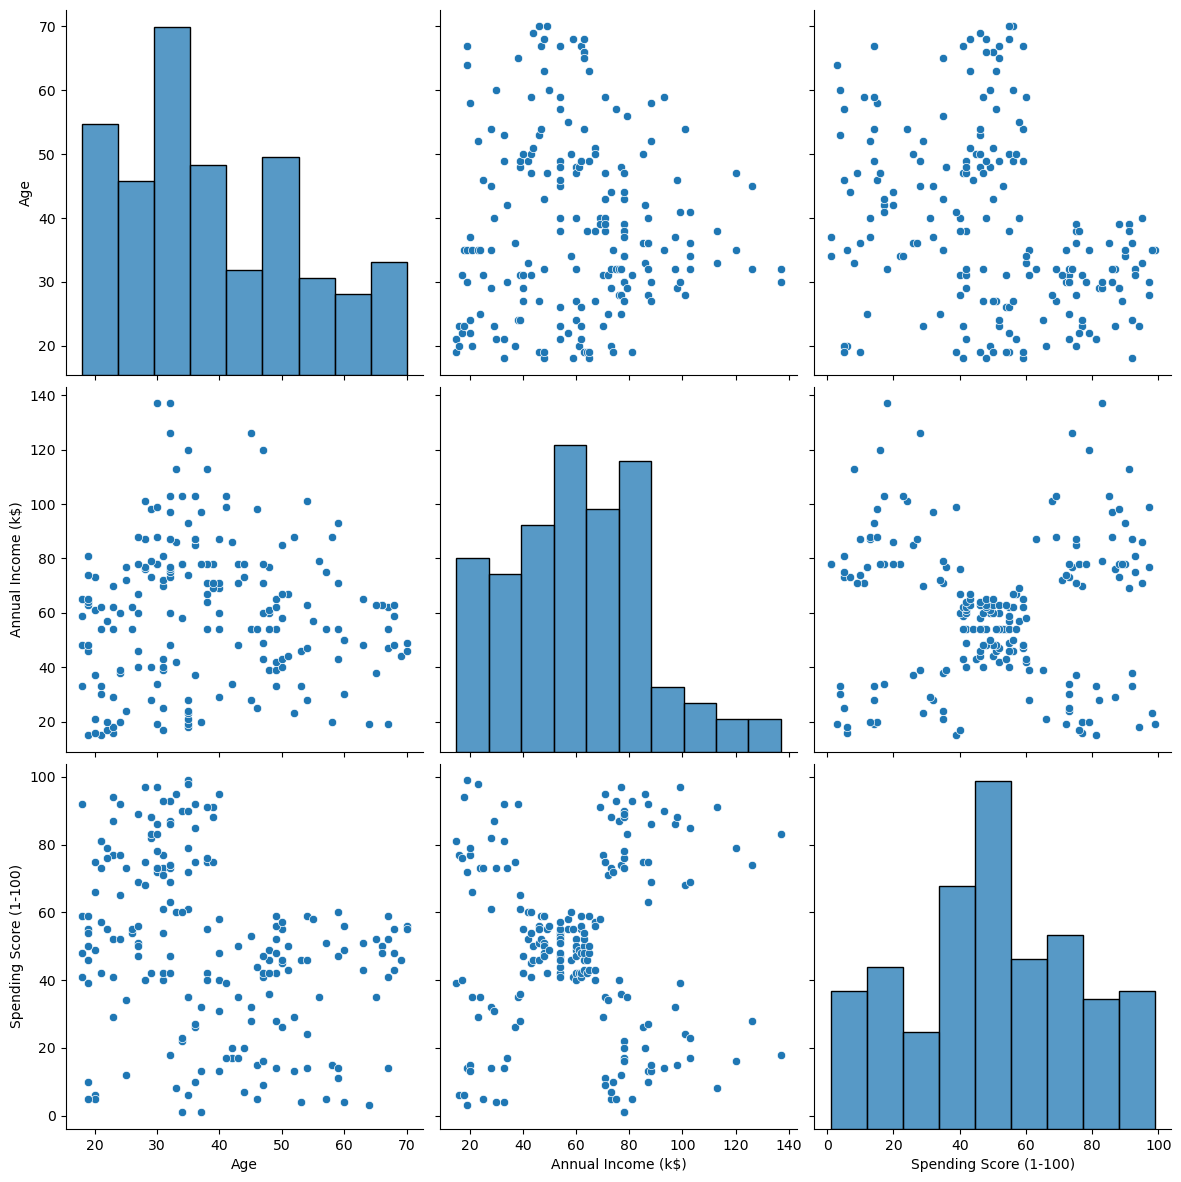

In [9]:
sns.pairplot(data, size=4,kind='scatter')

In [10]:
# Luego de revisar la distribución, analizamos las correlaciones de los datos
corr_matrix = data.corr()
corr_matrix

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


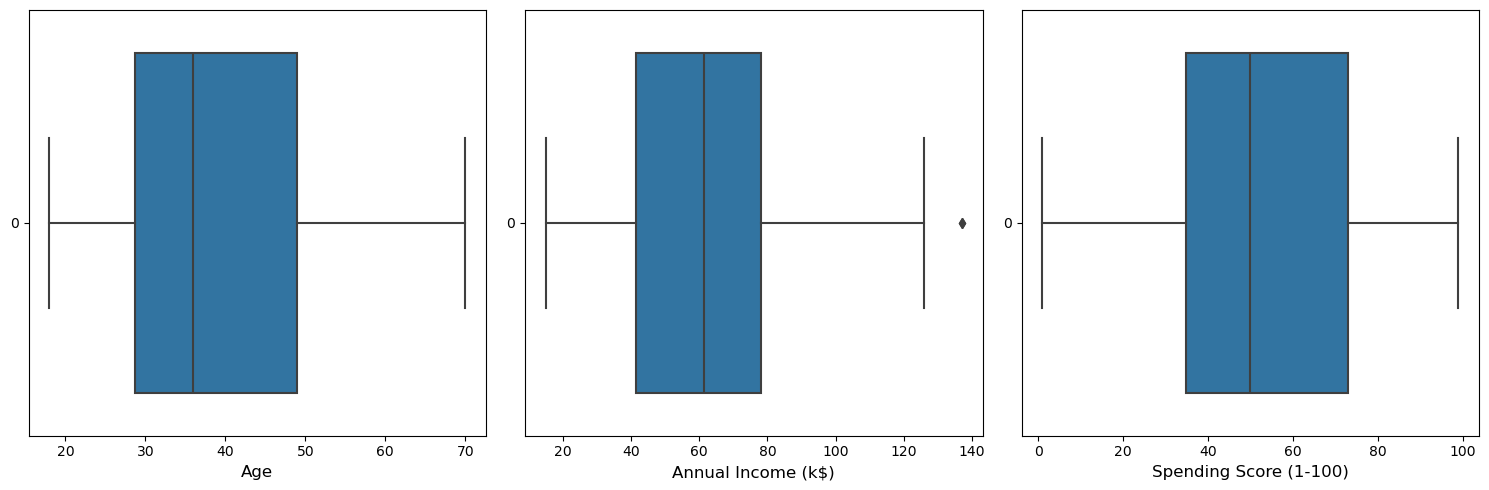

In [11]:
# Identificación de datos atípicos

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Mantenemos la disposición de filas y columnas

# Crear boxplot para 'edad'
sns.boxplot(data['Age'], ax=axs[0], orient='h')
axs[0].set_xlabel('Age', fontsize=12)  # Cambiamos a 'xlabel'

# Crear gráfico de barras para 'ingresoAnual'
sns.boxplot(data['Annual Income (k$)'], ax=axs[1], orient='h')
axs[1].set_xlabel('Annual Income (k$)', fontsize=12)  # Cambiamos a 'xlabel'

# Crear gráfico de barras para 'puntuacionGasto'
sns.boxplot(data['Spending Score (1-100)'], ax=axs[2], orient='h')
axs[2].set_xlabel('Spending Score (1-100)', fontsize=12)  # Cambiamos a 'xlabel'

plt.tight_layout()

Las variables no presentan una correlación significativamente alta entre ellas, hay una correlación negativa entre la edad y el Score.

Edad: La mayoría de los clientes tienen entre 20 y 40 años. Hay una distribución aproximadamente uniforme entre estas edades, con una ligera disminución después de los 40 años, no se presentan valores atipicos en la muestra.

Ingreso Anual: La distribución de ingresos anuales parece ser sesgada hacia la izquierda, lo que indica que la mayoría de los clientes tienen ingresos anuales más bajos. Sin embargo, hay algunos clientes con ingresos anuales más altos, como se evidencia por las barras en el extremo derecho del histograma, se debe tratar este campo para eliminar los valores atipicos encontrados.

Puntuación de Gasto: La puntuación de gasto presenta algunos picos en ciertos rangos. Esto sugiere que hay una variedad de clientes con diferentes niveles de puntuación de gasto, los score prevalentes estan puntuados entre 50 y 40, lo que indica que la mayoria de los clientes tienen un gasto medio.

# 2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario

En los diagramas de cajas vimos que no hay valores hacia el 0, pero igualmente revisaremos que no existan, dado que no tendria sentido en ninguno de los campos.

In [12]:
#Revisión de datos en 0

print("Cantidad de Registros con cero en edad: ",data['Age'].isin([0]).sum())
print("Cantidad de Registros con cero en ingresoAnual: ",data['Annual Income (k$)'].isin([0]).sum())
print("Cantidad de Registros con cero en puntuacionGasto: ",data['Spending Score (1-100)'].isin([0]).sum())

Cantidad de Registros con cero en edad:  0
Cantidad de Registros con cero en ingresoAnual:  0
Cantidad de Registros con cero en puntuacionGasto:  0


In [13]:
#Se crea la función para cambiar los valores atipicos por la mediana en una copia del dataset

def remplace_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    median = df[column].median()
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df.loc[df[column] > upper_bound, column] = median
    df.loc[df[column] < lower_bound, column] = median
    
# Se aplica la función para cada columna de la tabla con un ciclo for
data2 = data.copy();
columns_to_remplace_outliers = ['Annual Income (k$)'] 
for col in columns_to_remplace_outliers:
    remplace_outliers(data2, col)

<Axes: >

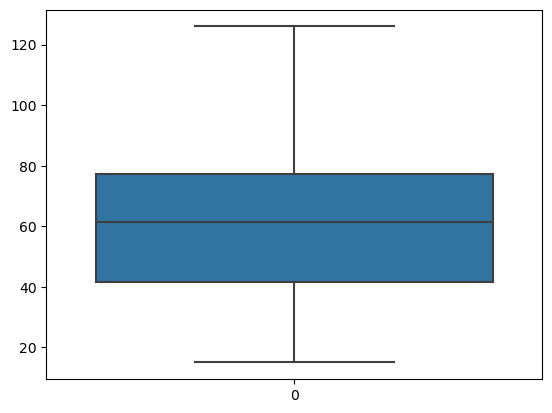

In [14]:
#revisamos nuevamente el diagrama de caja para comprobar
sns.boxplot(data=data2['Annual Income (k$)'])

# 3.Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características

In [15]:
# En el punto 1 durante la exploración ya se seleccionaron las caracteristicas Age, Annual Income (k$), Spending Score (1-100)
# Eliminaremos tambien la edad
data2 = data2.drop(['Age'], axis=1)

In [16]:
data2.head(10)

,Annual Income (k$),Spending Score (1-100)
0,15.0,39
1,15.0,81
2,16.0,6
3,16.0,77
4,17.0,40
5,17.0,76
6,18.0,6
7,18.0,94
8,19.0,3
9,19.0,72


# 4. Entrenar el modelo configurando los diferentes hiperparámetros

In [17]:
#Como primer paso preparamos la matriz de caracteristicas para realizar el clustering
X = data2[['Annual Income (k$)', 'Spending Score (1-100)']].values

In [18]:
#Realizamos el Hieracler clustering
linked = linkage(X, 'average')

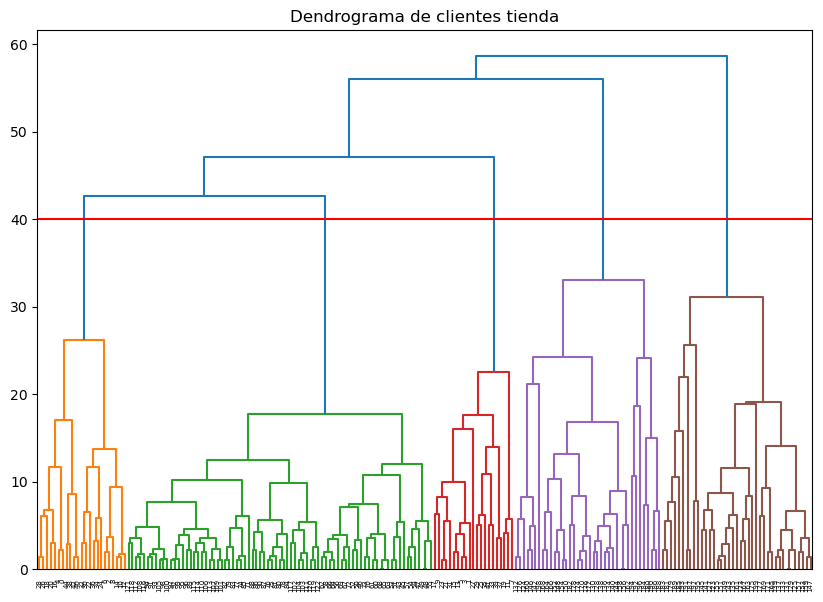

In [19]:
# Creamos el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
          orientation ='top',
          distance_sort = "descending",
          show_leaf_counts = True)
plt.axhline(y = 40, color = 'r', linestyle = '-')
plt.title('Dendrograma de clientes tienda')
plt.show()

Podemos analizar en el dendograma que tenemos 5 clusters bien definidos, uno de ellos parece que no esta bien compacto, sin embargo para estar seguros usaremos el metodo de indices silueta para confirmar el numero de clusters adecuados en nuestro modelo.

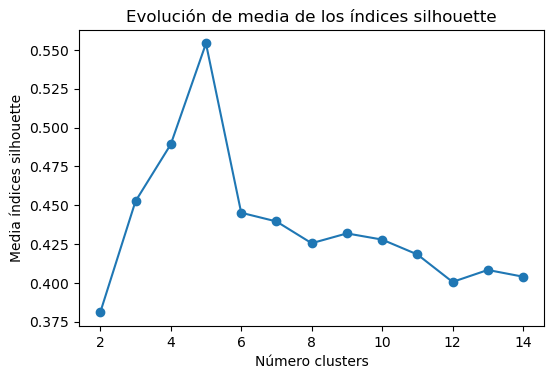

In [82]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []
for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )
    cluster_labels = modelo.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [20]:
#Decidimos el numero de clusteres y aplicamos el modelo
clustering = AgglomerativeClustering(n_clusters=5, linkage = 'average')
clustering.fit(X)

#Añadimos la asignacion de clusteres al dataframe
data2['Cluster'] = clustering.labels_
labels_hier = clustering.fit_predict(X)
labels_hier
data2

,Annual Income (k$),Spending Score (1-100),Cluster
0,15.0,39,2
1,15.0,81,3
2,16.0,6,2
3,16.0,77,3
4,17.0,40,2
...,...,...,...
195,120.0,79,1
196,126.0,28,0
197,126.0,74,1
198,61.5,18,0


# 5. Evaluar el desempeño del modelo con métricas

In [21]:
# Creamos las metricas para valorar el modelo
print("\nMedidas para Clustering Jerárquico:")
print("Puntaje de silueta:", silhouette_score(X, clustering.labels_))
print("Índice de Calinski-Harabasz:", calinski_harabasz_score(X, clustering.labels_))
print("Davies-Bouldin Index:", davies_bouldin_score(X, clustering.labels_))


Medidas para Clustering Jerárquico:
Puntaje de silueta: 0.5557910990183056
Índice de Calinski-Harabasz: 261.37063443267976
Davies-Bouldin Index: 0.5667833204268966


# 6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo

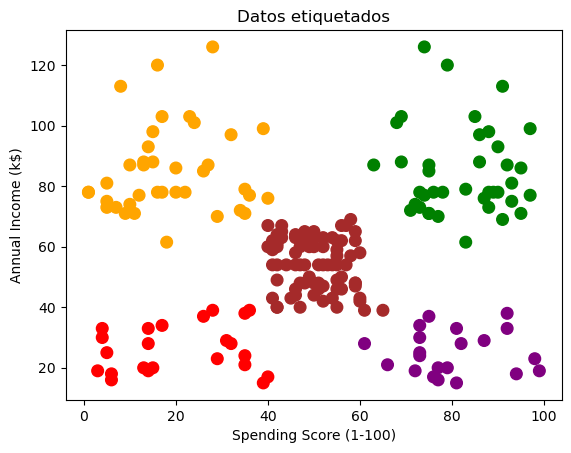

In [23]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = labels_hier
colores=['orange','green','red','purple', 'brown']
asignar=[]
for row in labels:
    asignar.append(colores[row])


f1 = data2['Spending Score (1-100)'].values
f2 = data2['Annual Income (k$)'].values
plt.scatter(f1, f2, c=asignar, s=70)
plt.title('Datos etiquetados')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Annual Income (k$)')
plt.show()

# 7. Interpretar, analizar y documentar los resultados obtenidos

**Puntaje de silueta (Silhouette Score):** El puntaje de silueta de 0.5557 sugiere que los puntos están relativamente bien agrupados en sus clusters respectivos. Un puntaje cercano a 1 indica clusters bien definidos y separados, sin embargo este valor es medio, por ende sus resultados no son tan fiables, se esperaria sobre un 0.7. 

**Índice de Calinski-Harabasz:** El índice de Calinski-Harabasz indica una buena dispersión entre los clusters y una baja dispersión dentro de los clusters. Esto sugiere que los clusters son compactos y bien separados entre sí, lo que es un indicador positivo de la calidad del clustering, el puntaje no es adecuado para lo esperado en el modelo.

**Davies-Bouldin Index:** El índice de Davies-Bouldin con un valor de 0.5667 es medio, lo ideal es lograr el puntaje mas bajo posible, esto con el fin de garantizar que los clusters son densos y bien separados entre sí. Un valor bajo es deseable en el índice de Davies-Bouldin, ya que indica una mejor separación entre los clusters, en este caso el valor esta incluso sobre el 0.5, por ende no es deseable.

La grafica nos deja comprobar las metricas, ya que podemos ver los cluster unos parecen estar bien definidos y compactos, los otros en su mayoria tienen una separación no tan clara y sus puntos tienen mucha distancia.

Con estos resultados podemos comprobar que el modelo se desempeña de una forma media, y no seria fiable para su uso, se debe examinar el uso de otros modelos de agrupación para determinar cual seria el mejor para este dataset.